In [1]:
from gurobipy import *

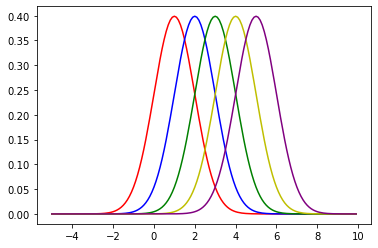

In [7]:
import numpy as np
from scipy.stats import norm
import math
import matplotlib.pyplot as plt

color=["r","b","g","y","purple"]

X=np.arange(-5,10,0.1)
for i in range(1,6):
  Y=norm.pdf(X,i,1)
  plt.plot(X,Y,color=color[i-1])
plt.show()

In [2]:
def IPS6(ship_num,stack_num,height,n,size,size_,beta,loc,scale):
  O1=[i+1 for i in range(ship_num)]
  S=[i+1 for i in range(stack_num)]
  H=[i+1 for i in range(height)]
  P=[i+1 for i in range(ship_num)]
  f=stack_num*height-sum(n)

  from asyncio.constants import SENDFILE_FALLBACK_READBUFFER_SIZE
  import random
  from random import seed
  import numpy as np
  from scipy.stats import multivariate_normal

  # 期待値と分散共分散行列の準備
  a=np.arange(1,ship_num+1,0.2)
  a=list(a)
  a=random.sample(a,ship_num)
  mean=np.sort(a)
  np.random.seed(0)
  cov=np.zeros((ship_num,ship_num))
  for i in range(ship_num):
      for j in range(ship_num):
          if i==j:
              cov[i][i]=abs(np.random.normal(loc=loc,scale=scale))
  for i in range(ship_num):
      for j in range(ship_num):
          if i!=j:
              cov[i][j]=0
  np.random.seed()
  data_1 = np.random.multivariate_normal(mean, cov, size=size)

  O_=np.argsort(data_1)
  O_=O_+np.ones((size,ship_num)).astype(int)
  O=O_.tolist()
  # a=[]
  # b={}
  # for i in O:
  #   # print(i)
  #   if not i in a:
  #     a.append(i)
  #     for j in a:
  #       b[tuple(j)]=O.count(j)

  m=Model("IPS6")

  alpha=m.addVar(vtype="C")

  # 変数の定義
  x,c,d={},{},{}
  for s in S:
    for h in H:
      for p in P:
        x[s,h,p]=m.addVar(vtype="B")

  for s in S:
    for h in range(2,len(H)+1):
      for i,o in enumerate(O):
        c[s,h,i]=m.addVar(vtype="C",lb=0)

  for i in range(len(O)):
    d[i]=m.addVar(vtype="C",lb=0)

  for p in P:
    m.addConstr(quicksum(x[s,h,p] for s in S for h in H)==n[p-1])

  for s in S:
    for h in H:
      m.addConstr(quicksum(x[s,h,p] for p in P)<=1)

  for s in S:
    for h in range(1,len(H)):
      m.addConstr(quicksum(x[s,h+1,p] for p in P)<=quicksum(x[s,h,p] for p in P))

  for s in S:
    for h in range(2,len(H)+1):
      for h_ in range(1,h):
        for i,o in enumerate(O):
          for j,p in enumerate(o):
            m.addConstr(c[s,h,i]>=quicksum(x[s,h,k] for k in o[j:])-quicksum(x[s,h_,k] for k in o[j:]))

  for i in range(len(O)):
    m.addConstr(d[i]>=quicksum(c[s,h,i] for s in S for h in H if h!=1)-alpha)


  m.setObjective(alpha+quicksum(d[i] for i in range(len(O)))/((1-beta)*len(O)))

  if f>=height:
    m.optimize()
  else:
    print("f<h")

  print("================================================")

# def result(self):
  EPS=1.e-6

  if m.Status == GRB.OPTIMAL:
    for (s,h,p) in x:
    # if t==len(T):
      if x[s,h,p].X>EPS:
        print("x[%2s,%2s,%2s]=%3s" %(s,h,p,x[s,h,p].X))

    for (s,h,i) in c:
      if c[s,h,i].X>EPS:
        print("c[%2s,%2s,%2s]=%3s %3s %4s" %(s,h,i,c[s,h,i].X,i,O[i]))

    global result
    result=np.zeros((height,stack_num))
    for (s,h,p) in x:
      if x[s,h,p].X>EPS:
    # print("x[%2s,%2s,%2s]=%3s  %4s" %(s,h,p,x[s,h,p].X,O[i]))
        result[height-h][s-1]=int(p)

    result=result.astype(int)
    print("VaR=",alpha.X)
    print("the objective function", m.objVal)
    print(result)

    np.random.seed()
    data_2 = np.random.multivariate_normal(mean, cov, size=size_)

    global OR
    OR_=np.argsort(data_2)
    OR_=OR_+np.ones((size_,ship_num)).astype(int)
    OR=OR_.tolist()

    global penalty
    penalty=[]
    for k in OR:
      O=k
      a=0
      for j in range(stack_num):
          for i in range(1,height):
              for i_ in range(i+1,height+1):
                  if result[i-1][j]!=0 and result[i_-1][j]!=0:
                      if O.index(result[i-1][j])>O.index(result[i_-1][j]):
                          print(j+1,height-i+1,O)
                          a+=1
                          # print("penalty!")
                              # print(i,i_,j+1,O)
                          break
      penalty.append(a)
      # print(a)
    penalty=np.sort(penalty)
    penalty=penalty[round(beta*size_):]
    # penalty=penalty[round(0.8*size):]
    # print(penalty)

def robust(ship_num,stack_num,height,n,Gamma,size,size_,loc,scale):
    # nと初期配置を変更しなければいけない
    num=sum(n)

    import numpy as np

    O1=[i+1 for i in range(ship_num)]

    Q=[i+1 for i in range(stack_num)]
    L=[i+1 for i in range(height)]
    P=[i+1 for i in range(ship_num)]
    I=[i+1 for i in range(num)]
    f=stack_num*height-len(I)
    a=1
    gamma=[]
    for i in n:
        for j in range(1,i+1):
            gamma.append(a)
        a+=1
    
    m=Model("BI")

    # 変数の定義
    alpha,beta={},{}
    for i in I:
        for q in Q:
            alpha[i,q]=m.addVar(vtype="B")
            beta[i,q]=m.addVar(vtype="B")
    J=[]
    for i in I:
        J.append([])
        for j in I:
            if gamma[i-1]<gamma[j-1]:
                if gamma[j-1]-gamma[i-1]<=Gamma:
                    J[i-1].append(j)

    for q in Q:
        m.addConstr(quicksum((alpha[i,q]+beta[i,q]) for i in I)<=len(L))

    for i in I:
        m.addConstr(quicksum((alpha[i,q]+beta[i,q]) for q in Q)==1)

    for i in I:
        for j in J[i-1]:
            for q in Q:
                m.addConstr(alpha[i,q]+alpha[j,q]+beta[j,q]<=1)

    m.setObjective(quicksum(beta[i,q] for i in I for q in Q))

    if f>=height:
        m.optimize()

    EPS=1.e-6

    if m.Status == GRB.OPTIMAL:
        print("====================================================")
        # for (s,h,p,t) in x:
        #   if t==len(T):
        #     if x[s,h,p,t].X>EPS:
        #       print("x[%2s,%2s,%2s,%2s]=%3s" %(s,h,p,t,x[s,h,p,t].X)

        for (i,q) in beta:
            if beta[i,q].X>EPS:
                print("beta[%2s,%2s]=%3s" %(gamma[i-1],q,beta[i,q].X))

        EPS=1.e-6
        a=[]
        for q in Q:
            a.append([])
        for (i,q) in alpha:
            if alpha[i,q].X>EPS:
                a[q-1].append(gamma[i-1])
        
        for (i,q) in beta:
            if beta[i,q].X>EPS:
                a[q-1].append(gamma[i-1])

        for q in Q:
            a[q-1]=sorted(a[q-1],reverse=True)

        global result_r
        result_r=np.zeros((height,stack_num))
        for q in Q:
            for i,r in enumerate(a[q-1]):
                result_r[height-i-1][q-1]=r
            # print(i,r)

        result_r=result_r.astype(int)
        
        print(result_r)
        print("the objective function", m.objVal)

        from asyncio.constants import SENDFILE_FALLBACK_READBUFFER_SIZE
        import random
        from random import seed
        import numpy as np
        from scipy.stats import multivariate_normal

        # 期待値と分散共分散行列の準備
        mean=np.arange(1,ship_num+1)
        # a=list(a)
        # a=random.sample(a,ship_num)
        # mean=np.sort(a)
        np.random.seed(0)
        cov=np.zeros((ship_num,ship_num))
        for i in range(ship_num):
            for j in range(ship_num):
                if i==j:
                    cov[i][i]=abs(np.random.normal(loc=loc,scale=scale))
        for i in range(ship_num):
            for j in range(ship_num):
                if i!=j:
                    cov[i][j]=0
        np.random.seed()
        data_1 = np.random.multivariate_normal(mean, cov, size=size_)

        O_=np.argsort(data_1)
        O_=O_+np.ones((size_,ship_num)).astype(int)
        OR=O_.tolist()


        global penalty_r
        penalty_r=[]
        for k in OR:
            O=k
            a=0
            for j in range(stack_num):
                for i in range(1,height):
                    for i_ in range(i+1,height+1):
                        if result_r[i-1][j]!=0 and result_r[i_-1][j]!=0:
                            if O.index(result_r[i-1][j])>O.index(result_r[i_-1][j]):
                                print(j+1,height-i+1,O)
                                a+=1
                                # print("penalty!")
                                # print(i,i_,j+1,O)
                                break
            penalty_r.append(a)
        
        penalty_r=np.sort(penalty_r)
        penalty_r=penalty_r[round(0.75*size_):]
        print(penalty_r)

        # import matplotlib.pyplot as plt
        # plt.boxplot(penalty_r)

Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (win64)
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads
Optimize a model with 29034 rows, 2697 columns and 233536 nonzeros
Model fingerprint: 0x3861743e
Variable types: 2601 continuous, 96 integer (96 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [2e-02, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 2e+00]
Presolve removed 9280 rows and 832 columns
Presolve time: 0.30s
Presolved: 19754 rows, 1865 columns, 158912 nonzeros
Variable types: 1769 continuous, 96 integer (96 binary)
Found heuristic solution: objective 6.3800000
Found heuristic solution: objective 4.0000000

Use crossover to convert LP symmetric solution to basic solution...

Root relaxation: objective 0.000000e+00, 476 iterations, 0.09 seconds (0.11 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd  

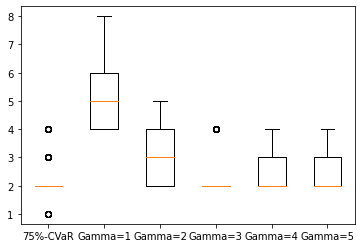

In [8]:
size=200
size_=2000
loc=10
scale=1
inst=[[4,4,[2,2,2,2,2,2]]]
pcvar=[]
for i in inst:
  ship_num=len(i[2])
  IPS6(ship_num,i[0],i[1],i[2],size,size_,0.75,loc,scale)
  pcvar+=list(penalty)
data=(tuple(pcvar),)
l=["75%-CVaR"]
for g in range(1,6):
  prob=[]
  for i in inst:
    ship_num=len(i[2])
    robust(ship_num,i[0],i[1],i[2],g,size,size_,loc,scale)
    prob+=list(penalty_r)
    print(prob)
  data+=(tuple(prob),)
  l.append("Gamma="+str(g))
  # print("data=",data)
import matplotlib.pyplot as plt
plt.boxplot(data,labels=l)
plt.show()